# Proyek Klasifikasi Gambar: [Animal Faces]
- **Nama:** Meysi Supmawati
- **Email:** meysi.supmawati25@gmail.com
- **ID Dicoding:** meysi supmawati

## Import Library

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
import random
import cv2
from tensorflow.keras.regularizers import l2
from IPython.display import display, FileLink
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow_hub as hub
from tensorflow import keras

2025-04-28 05:53:27.940723: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745819608.139229      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745819608.197421      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Data Preparation

In [2]:
# Direktori dataset
data_dir = '/kaggle/input/animal-faces/afhq'
if not os.path.exists(data_dir):
    raise FileNotFoundError(f"Dataset tidak ditemukan di {data_dir}")

# Terjemahan nama kelas
translate = {
    "dog": "Anjing",
    "cat": "Kucing",
    "wild": "Margasatwa"
}

# Mengumpulkan data gambar dari folder 'train' dan 'val'
data = []
for split in ['train', 'val']:
    split_dir = os.path.join(data_dir, split)
    for class_name in os.listdir(split_dir):
        class_dir = os.path.join(split_dir, class_name)
        if os.path.isdir(class_dir):
            label = translate.get(class_name.lower(), class_name)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                if img_path.lower().endswith(('.jpg', '.jpeg', '.png')):
                    data.append([img_path, label])

# Membuat DataFrame
df = pd.DataFrame(data, columns=['path', 'class'])

# Menyeimbangkan jumlah data per kelas (maksimal 1400 per kelas)
df_balanced = (
    df.groupby('class', group_keys=False, sort=False)
      .apply(lambda x: x.sample(min(len(x), 1400), random_state=42))
      .reset_index(drop=True)
)

# Menampilkan jumlah gambar per kelas
print("Jumlah gambar per kelas setelah balancing:")
print(df_balanced['class'].value_counts())

Jumlah gambar per kelas setelah balancing:
class
Anjing        1400
Margasatwa    1400
Kucing        1400
Name: count, dtype: int64


/tmp/ipykernel_31/1511301783.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min(len(x), 1400), random_state=42))


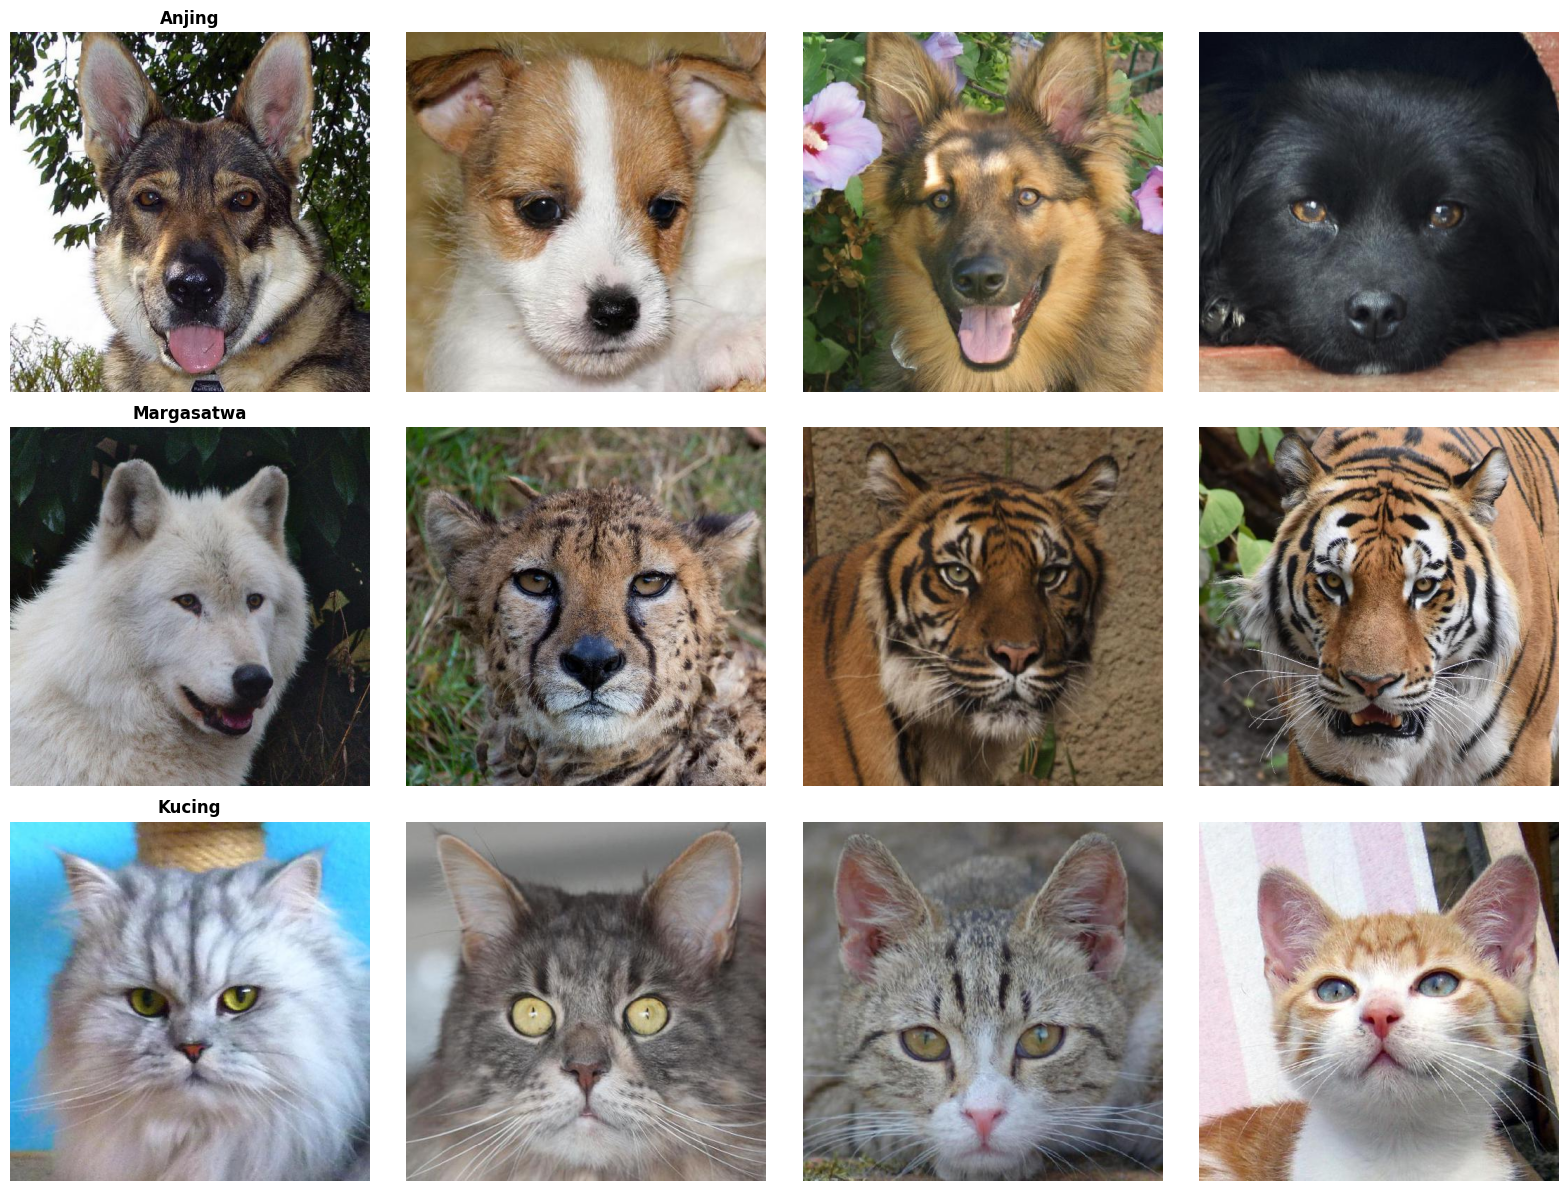

In [3]:
# Fungsi untuk menampilkan sampel gambar
def plot_sample_images(df, num_images=4):
    unique_classes = df['class'].unique()
    fig, axes = plt.subplots(len(unique_classes), num_images, figsize=(num_images * 4, len(unique_classes) * 4))

    for i, class_name in enumerate(unique_classes):
        sample_images = df[df['class'] == class_name].sample(n=min(num_images, len(df[df['class'] == class_name])), random_state=42)
        for j, (_, row) in enumerate(sample_images.iterrows()):
            img = cv2.imread(row['path'])
            if img is None:
                continue  # Lewati gambar yang tidak bisa dibaca
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[i, j].imshow(img)
            axes[i, j].axis("off")
            if j == 0:
                axes[i, j].set_title(class_name, fontsize=12, fontweight="bold")

    plt.tight_layout()
    plt.show()

# Tampilkan gambar
plot_sample_images(df_balanced)

## Data Preprocessing

#### Data Splitting & Image Data Generator

In [4]:
# Split data menjadi training dan testing set (80:20)
TRAIN_DF, TEST_DF = train_test_split(
    df_balanced,
    test_size=0.2,
    stratify=df_balanced['class'],
    random_state=42
)

# ImageDataGenerator untuk training dan validation (dari TRAIN_DF)
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.2,  # 20% dari TRAIN_DF untuk validasi
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Generator untuk training
train_generator = train_datagen.flow_from_dataframe(
    dataframe=TRAIN_DF,
    x_col='path',
    y_col='class',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=16,
    shuffle=True,
    subset='training',
    seed=42
)

# Generator untuk validation
val_generator = train_datagen.flow_from_dataframe(
    dataframe=TRAIN_DF,
    x_col='path',
    y_col='class',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    subset='validation',
    seed=42
)

# ImageDataGenerator untuk testing
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Generator untuk testing
test_generator = test_datagen.flow_from_dataframe(
    dataframe=TEST_DF,
    x_col='path',
    y_col='class',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 2688 validated image filenames belonging to 3 classes.
Found 672 validated image filenames belonging to 3 classes.
Found 840 validated image filenames belonging to 3 classes.


In [5]:
# Informasi jumlah data
print(f"Total data setelah balancing: {len(df_balanced)}")
print(f"Total training data: {len(TRAIN_DF)}")  
print(f"Total testing data: {len(TEST_DF)}")

Total data setelah balancing: 4200
Total training data: 3360
Total testing data: 840


## Modelling

#### Transfer Learning EfficientNetV2S

In [6]:
!pip install tensorflow-hub

In [7]:
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Input

# Load base model EfficientNetV2S dengan bobot ImageNet
base_model = EfficientNetV2S(weights="imagenet",include_top=False,input_shape=(224, 224, 3))
base_model.trainable = True  # Fine-tune seluruh base model

from tensorflow.keras import layers, models

# Model harus Sequential dan harus ada Conv2D + Pooling
model = Sequential([
    Input(shape=(224, 224, 3)),
    base_model,
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(3, activation='softmax')  # 3 kelas: Anjing, Margasatwa, Kucing
])

# Kompilasi model dengan optimizer dan metrik
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall")
        # F1Score bisa ditambahkan manual kalau diperlukan, TensorFlow belum native support penuh
    ]
)

# Tampilkan arsitektur model
model.summary()

I0000 00:00:1745819643.441770      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745819643.442546      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetv2-s (Functional)        │ (None, 7, 7, 1280)          │      20,331,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 7, 7, 32)            │         368,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 3, 3, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 32)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,704,643 (78.98 MB)

 Trainable params: 20,550,771 (78.39 MB)

 Non-trainable params: 153,872 (601.06 KB)

In [8]:
# EarlyStopping callback untuk menghentikan training jika tidak ada peningkatan
stop_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-3,
    patience=3,
    restore_best_weights=True
)

# Training model
epochs = 15
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[stop_callback]
)


Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745819764.439293     105 service.cc:148] XLA service 0x7d24f0987fc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745819764.440192     105 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745819764.440218     105 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1745819774.664207     105 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1745819789.219893     105 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing war

168/168 ━━━━━━━━━━━━━━━━━━━━ 250s 430ms/step - accuracy: 0.5495 - loss: 0.9508 - precision: 0.7567 - recall: 0.1878 - val_accuracy: 0.9524 - val_loss: 0.3729 - val_precision: 0.9847 - val_recall: 0.8631
Epoch 2/15
168/168 ━━━━━━━━━━━━━━━━━━━━ 43s 249ms/step - accuracy: 0.9313 - loss: 0.3068 - precision: 0.9562 - recall: 0.8824 - val_accuracy: 0.9747 - val_loss: 0.1340 - val_precision: 0.9789 - val_recall: 0.9658
Epoch 3/15
168/168 ━━━━━━━━━━━━━━━━━━━━ 43s 244ms/step - accuracy: 0.9552 - loss: 0.1506 - precision: 0.9621 - recall: 0.9474 - val_accuracy: 0.9881 - val_loss: 0.0742 - val_precision: 0.9910 - val_recall: 0.9836
Epoch 4/15
168/168 ━━━━━━━━━━━━━━━━━━━━ 43s 250ms/step - accuracy: 0.9670 - loss: 0.1004 - precision: 0.9703 - recall: 0.9638 - val_accuracy: 0.9777 - val_loss: 0.0637 - val_precision: 0.9835 - val_recall: 0.9762
Epoch 5/15
168/168 ━━━━━━━━━━━━━━━━━━━━ 43s 247ms/step - accuracy: 0.9797 - loss: 0.0625 - precision: 0.9799 - recall: 0.9789 - val_accuracy: 0.9881 - val_los

## Evaluasi dan Visualisasi

#### Plot Akurasi, Plot Loss dan F1 Score

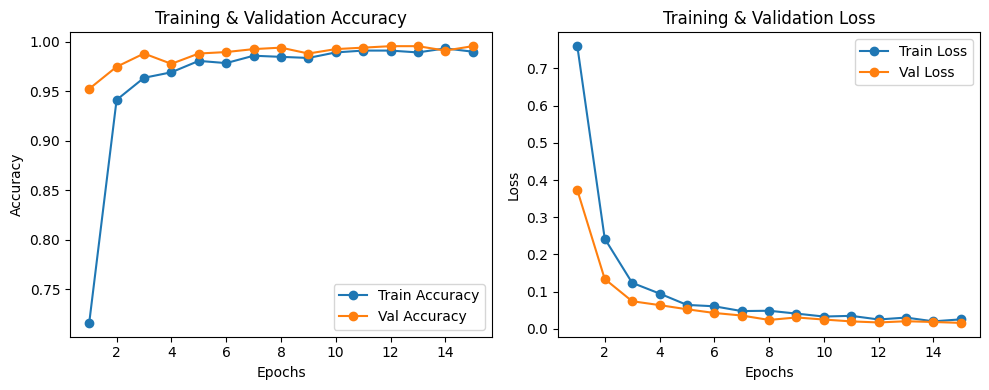

In [9]:
# Ambil metrik dari hasil training
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(1, len(train_acc) + 1)

plt.figure(figsize=(10, 4))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label="Train Accuracy", marker="o")
plt.plot(epochs_range, val_acc, label="Val Accuracy", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training & Validation Accuracy")

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label="Train Loss", marker="o")
plt.plot(epochs_range, val_loss, label="Val Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss")

plt.tight_layout()
plt.show()

In [10]:
from sklearn.metrics import classification_report, f1_score

# Prediksi label dari validation set
val_preds = model.predict(val_generator)
y_pred = val_preds.argmax(axis=1)
y_true = val_generator.classes

# Hitung F1 Score (macro average)
f1_macro = f1_score(y_true, y_pred, average='macro')
print(f"F1 Score (Macro): {f1_macro:.4f}")

# Classification report lengkap
print(classification_report(y_true, y_pred, target_names=val_generator.class_indices.keys()))


21/21 ━━━━━━━━━━━━━━━━━━━━ 19s 347ms/step
F1 Score (Macro): 0.9942
              precision    recall  f1-score   support

      Anjing       0.99      1.00      0.99       225
      Kucing       1.00      1.00      1.00       210
  Margasatwa       1.00      0.99      0.99       237

    accuracy                           0.99       672
   macro avg       0.99      0.99      0.99       672
weighted avg       0.99      0.99      0.99       672



#### Evaluasi Perfoma Model

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


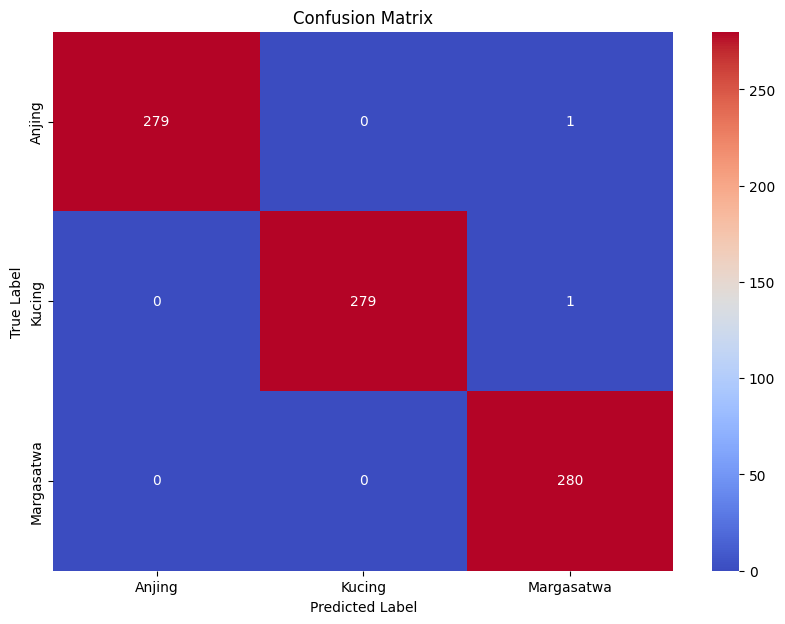


Classification Report:

              precision    recall  f1-score   support

      Anjing     1.0000    0.9964    0.9982       280
      Kucing     1.0000    0.9964    0.9982       280
  Margasatwa     0.9929    1.0000    0.9964       280

    accuracy                         0.9976       840
   macro avg     0.9976    0.9976    0.9976       840
weighted avg     0.9976    0.9976    0.9976       840



In [11]:
# Reset test generator untuk prediksi akurat
test_generator.reset()

# Prediksi label
preds = model.predict(test_generator, verbose=0)
pred_labels = np.argmax(preds, axis=1)

# Label sebenarnya
true_labels = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)

# Visualisasi Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true=true_labels,
                            y_pred=pred_labels,
                            target_names=class_names,
                            digits=4))


## Konversi Model

In [12]:
# Simpan ke format Keras (.keras) dan HDF5 (.h5)
model.save("model.keras")
model.save("model.h5")

# Konversi ke TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open("model.tflite", "wb") as f:
    f.write(tflite_model)

# Konversi ke TensorFlow.js
!pip install tensorflowjs
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model, "model_tfjs")

# Simpan ke format TensorFlow SavedModel (untuk TFLite/TFServing)
model.export("saved_model")  # ← INI yang benar untuk format SavedModel di Keras 3

Saved artifact at '/tmp/tmp5uwmlb8q'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_513')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  137603474967440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137601312388688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137601312376400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137601312376016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137601312388496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137601312376208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137601312388112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137601304776144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137603474965520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137601312375632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1376013047

W0000 00:00:1745820621.564652      31 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1745820621.564685      31 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1745820621.929018      31 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.1 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.5.0 requires fsspec[http]<=2024.12.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.
nilearn 0.11.1 requires scikit-learn>=1.4.0, but you have scikit-learn 1.2.2 which is incompatible.
pandas-gbq 0.26.1 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.5 which is 

failed to lookup keras version from the file,
    this is likely a weight only file
Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_513')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  137603474967440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137601312388688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137601312376400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137601312376016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137601312388496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137601312376208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137601312388112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137601304776144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137603474965520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1

In [13]:
# Kompres masing-masing format model
!zip model_keras.zip model.keras
!zip model_h5.zip model.h5
!zip -r model_saved.zip saved_model/
!zip model_tflite.zip model.tflite
!zip -r model_tfjs.zip model_tfjs/

  adding: model.keras (deflated 8%)
  adding: model.h5 (deflated 8%)
  adding: saved_model/ (stored 0%)
  adding: saved_model/saved_model.pb (deflated 92%)
  adding: saved_model/assets/ (stored 0%)
  adding: saved_model/variables/ (stored 0%)
  adding: saved_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: saved_model/variables/variables.index (deflated 77%)
  adding: saved_model/fingerprint.pb (stored 0%)
  adding: model.tflite (deflated 7%)
  adding: model_tfjs/ (stored 0%)
  adding: model_tfjs/group1-shard12of20.bin (deflated 7%)
  adding: model_tfjs/model.json (deflated 97%)
  adding: model_tfjs/group1-shard17of20.bin (deflated 7%)
  adding: model_tfjs/group1-shard5of20.bin (deflated 7%)
  adding: model_tfjs/group1-shard6of20.bin (deflated 7%)
  adding: model_tfjs/group1-shard20of20.bin (deflated 7%)
  adding: model_tfjs/group1-shard7of20.bin (deflated 7%)
  adding: model_tfjs/group1-shard16of20.bin (deflated 7%)
  adding: model_tfjs/group1-shard2of20.bin (defl

In [14]:
display(FileLink('model_keras.zip'))
display(FileLink('model_h5.zip'))
display(FileLink('model_saved.zip'))
display(FileLink('model_tflite.zip'))
display(FileLink('model_tfjs.zip'))

/kaggle/working/model_keras.zip

/kaggle/working/model_h5.zip

/kaggle/working/model_saved.zip

/kaggle/working/model_tflite.zip

/kaggle/working/model_tfjs.zip

In [15]:
# Simpan dan tampilkan requirements.txt
!pip freeze > requirements.txt
display(FileLink("requirements.txt"))

/kaggle/working/requirements.txt

## Inference (TF-Lite)

In [16]:
import zipfile

# Ekstrak model TFLite
with zipfile.ZipFile("model_tflite.zip", "r") as zip_ref:
    zip_ref.extractall("model_tflite")



INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


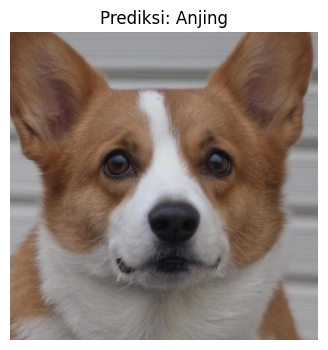

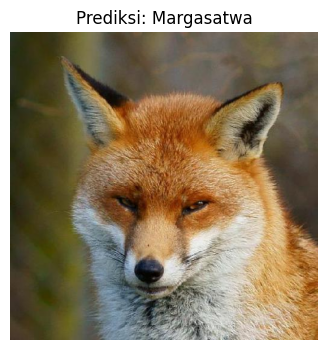

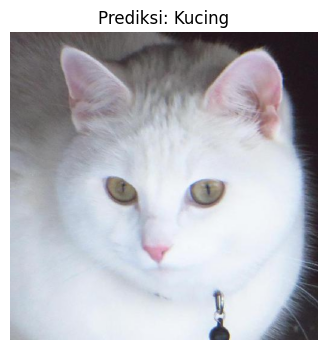

In [17]:
# Load TFLite interpreter
interpreter = tf.lite.Interpreter(model_path="model_tflite/model.tflite")
interpreter.allocate_tensors()

# Ambil detail input/output dari model
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_shape = input_details[0]['shape']  # Umumnya (1, 224, 224, 3)

# Path ke gambar-gambar uji
img_paths = [
    "/kaggle/input/animal-faces/afhq/val/dog/flickr_dog_000193.jpg",
    "/kaggle/input/animal-faces/afhq/val/wild/flickr_wild_000040.jpg",
    "/kaggle/input/animal-faces/afhq/train/cat/flickr_cat_000025.jpg"
]

# Mapping indeks ke label kelas (versi Indonesia)
idx_to_class_indo = {
    0: "Anjing", 1: "Kucing", 2: "Margasatwa"
}

# Preprocessing gambar
batch_imgs = []
for img_path in img_paths:
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    batch_imgs.append(img_array)

batch_imgs = np.array(batch_imgs, dtype=np.float32)

# Lakukan prediksi per gambar (jika dimensi batch input = 1)
if len(input_shape) == 4 and input_shape[0] == 1:
    for i in range(len(batch_imgs)):
        img_array = np.expand_dims(batch_imgs[i], axis=0)
        
        interpreter.set_tensor(input_details[0]['index'], img_array)
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])
        
        predicted_idx = np.argmax(output_data)
        predicted_class = idx_to_class_indo[predicted_idx]
        
        # Tampilkan gambar dan hasil prediksi
        plt.figure(figsize=(4, 4))
        plt.imshow(image.load_img(img_paths[i]))
        plt.axis("off")
        plt.title(f"Prediksi: {predicted_class}")
        plt.show()
else:
    # Jika model mendukung batch langsung
    interpreter.set_tensor(input_details[0]['index'], batch_imgs)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])

    predicted_idxs = np.argmax(output_data, axis=1)

    plt.figure(figsize=(12, 4))
    for i in range(len(img_paths)):
        plt.subplot(1, 3, i+1)
        plt.imshow(image.load_img(img_paths[i]))
        plt.axis("off")
        plt.title(f"Prediksi: {idx_to_class_indo[predicted_idxs[i]]}")
    plt.show()